In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('../')

In [3]:
from traffic_light_color_detection.model import ColorSpace
from traffic_light_color_detection.color_spaces import ColorModelFactory

In [4]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import cv2
import time
import pandas as pd
import numpy as np
import json

from PIL import Image
import torch
import torchvision
import torchvision.transforms as T

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

DIR_INPUT = '/content/drive/MyDrive/UNT/CSCE 5222/traffic_light_dataset/kaggle_dataset/'
DIR_IMAGES = DIR_INPUT + "train_dataset/train_images/"
DIR_IMAGES_TEST = DIR_INPUT + "train_dataset/test_images/"

In [5]:
files = os.listdir(DIR_IMAGES)

# Count the number of images
num_images = len(files)

print(f"Number of images: {num_images}")

Number of images: 2600


## Extract labels about bounding box and light color from json file

In [6]:
with open(DIR_INPUT+"/train_dataset/train.json") as f:
    data_dict = json.load(f)

# Create a list containing the data rows of the table
data = []

# Loop through the elements in the annotations list
for annotation in data_dict['annotations']:
    # Get general bounding box information
    filename = annotation['filename']
    xmin = annotation['bndbox']['xmin']
    ymin = annotation['bndbox']['ymin']
    xmax = annotation['bndbox']['xmax']
    ymax = annotation['bndbox']['ymax']

    if annotation['inbox']:
        for inbox in annotation['inbox']:
            color = inbox['color']
            data.append({
                    'filename': filename,
                    'xmin': xmin,
                    'ymin': ymin,
                    'xmax': xmax,
                    'ymax': ymax,
                    'color': color,
                })


# Create a DataFrame from a list of data and save it to a CSV file
df = pd.DataFrame(data)
df.to_csv('traffic_lights.csv', index=False)

In [7]:
data_tf = pd.read_csv('/content/traffic_lights.csv')


In [8]:
data_tf

filename    xmin    ymin    xmax    ymax  color
0     train_images\00001.jpg  1026.5   741.8  1077.5   910.9    red
1     train_images\00002.jpg  1418.7  1136.8  1428.3  1149.4    red
2     train_images\00003.jpg  2574.3   868.7  2632.3   887.1    red
3     train_images\00003.jpg  2252.1   899.6  2300.8   918.7  green
4     train_images\00004.jpg   833.3  1163.2   843.6  1184.8  green
...                      ...     ...     ...     ...     ...    ...
9417  train_images\03000.jpg    78.8  1001.7   107.7  1033.1    red
9418  train_images\03000.jpg  1234.8  1058.4  1251.0  1096.4  green
9419  train_images\03000.jpg  1264.9  1068.1  1287.6  1086.1  green
9420  train_images\03000.jpg  1296.0  1056.6  1311.7  1096.2  green
9421  train_images\03000.jpg  1346.5  1057.5  1360.8  1096.6  green

[9422 rows x 6 columns]

In [9]:
data_tf['filename'] = data_tf['filename'].str.replace('train_images\\\\', '', regex=True)
data_tf.to_csv('traffic_lights_labels.csv', index=False)

In [10]:
df = pd.read_csv('/content/traffic_lights_labels.csv')
df

filename    xmin    ymin    xmax    ymax  color
0     00001.jpg  1026.5   741.8  1077.5   910.9    red
1     00002.jpg  1418.7  1136.8  1428.3  1149.4    red
2     00003.jpg  2574.3   868.7  2632.3   887.1    red
3     00003.jpg  2252.1   899.6  2300.8   918.7  green
4     00004.jpg   833.3  1163.2   843.6  1184.8  green
...         ...     ...     ...     ...     ...    ...
9417  03000.jpg    78.8  1001.7   107.7  1033.1    red
9418  03000.jpg  1234.8  1058.4  1251.0  1096.4  green
9419  03000.jpg  1264.9  1068.1  1287.6  1086.1  green
9420  03000.jpg  1296.0  1056.6  1311.7  1096.2  green
9421  03000.jpg  1346.5  1057.5  1360.8  1096.6  green

[9422 rows x 6 columns]

## Data exploration and visualization

In [11]:
df.head()

filename    xmin    ymin    xmax    ymax  color
0  00001.jpg  1026.5   741.8  1077.5   910.9    red
1  00002.jpg  1418.7  1136.8  1428.3  1149.4    red
2  00003.jpg  2574.3   868.7  2632.3   887.1    red
3  00003.jpg  2252.1   899.6  2300.8   918.7  green
4  00004.jpg   833.3  1163.2   843.6  1184.8  green

In [12]:
unq_values = df["filename"].unique()
print("Total Records: ", len(df))
print("Unique Images: ",len(unq_values))

null_values = df.isnull().sum(axis = 0)
print("\n> Null Values in each column <")
print(null_values)

Total Records:  9422
Unique Images:  2470

> Null Values in each column <
filename    0
xmin        0
ymin        0
xmax        0
ymax        0
color       0
dtype: int64


In [13]:
classes = df["color"].unique()
print("Total Classes: ",len(classes))
print("\n> Classes <\n",classes)

Total Classes:  3

> Classes <
 ['red' 'green' 'yellow']


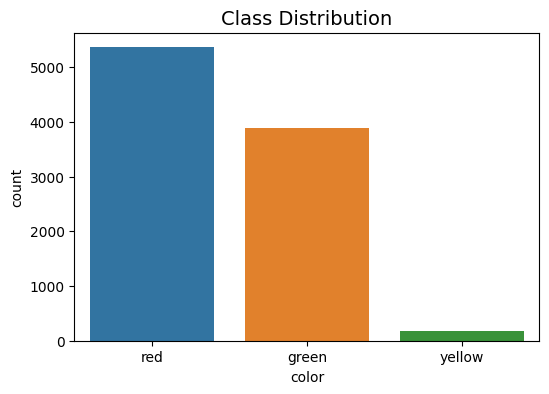

In [14]:
plt.figure(figsize=(6, 4))
plt.title('Class Distribution', fontsize= 14)
sns.countplot(x = "color", data = df);

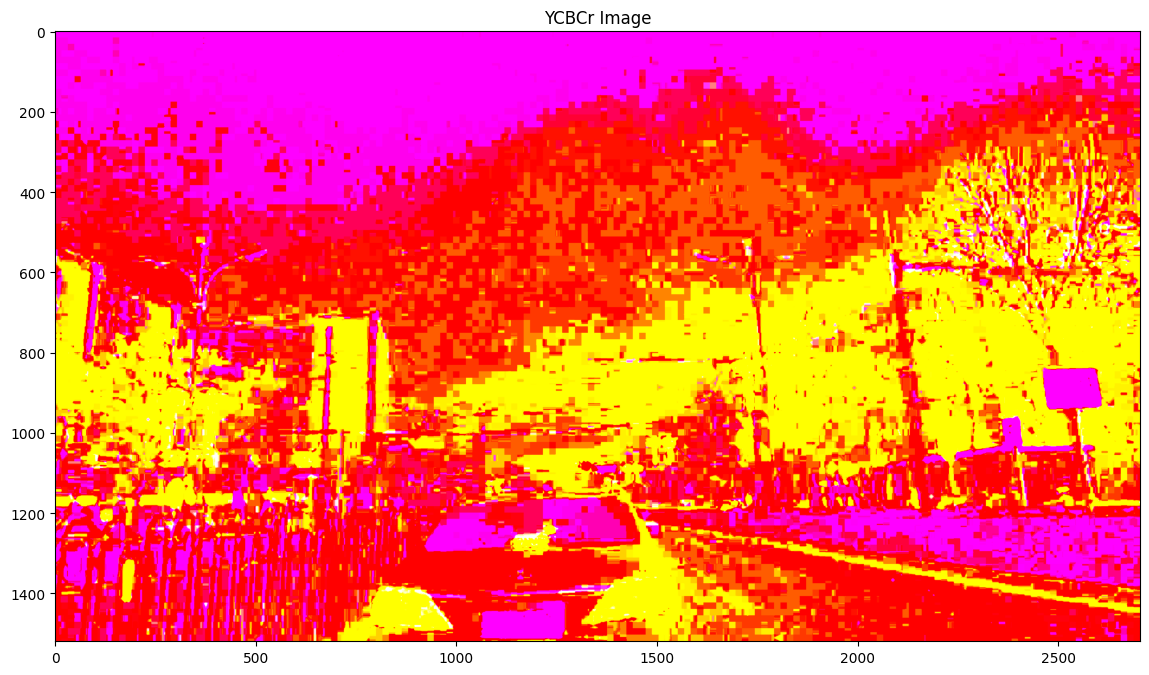

In [16]:
my_image_name = "00004.jpg"
my_img_path = os.path.join(DIR_IMAGES, my_image_name)

my_image = cv2.imread(my_img_path, cv2.IMREAD_COLOR)
my_ycbcr_image = ColorModelFactory.to_color_space(ColorSpace.YCBCr, my_image)
fig, ax = plt.subplots(1, 1, figsize = (14, 14))
ax.set_title('YCBCr Image')
ax.imshow(my_ycbcr_image)
plt.show()

In [53]:
def plot_img(image_name):

    fig, ax = plt.subplots(2, 1, figsize = (14, 14))
    ax = ax.flatten()

    bbox = df[df['filename'] == image_name]
    img_path = os.path.join(DIR_IMAGES, image_name)

    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image2 = image

    ax[0].set_title('Original Image')
    ax[0].imshow(image)

    for idx, row in bbox.iterrows():
        x1 = row['xmin']
        y1 = row['ymin']
        x2 = row['xmax']
        y2 = row['ymax']
        label = row['color']
        if label == 'red':
            color_brg = (255,0,0)
        elif label == 'green':
            color_brg = (0,255,0)
        elif label == 'yellow':
            color_brg = (0,255,255)

        cv2.rectangle(image2, (int(x1),int(y1)), (int(x2),int(y2)), color_brg, 3)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image2, label, (int(x1),int(y1-10)), font, 1, color_brg, 2)

    ax[1].set_title('Image with Bondary Box')
    ax[1].imshow(image2)

    plt.show()

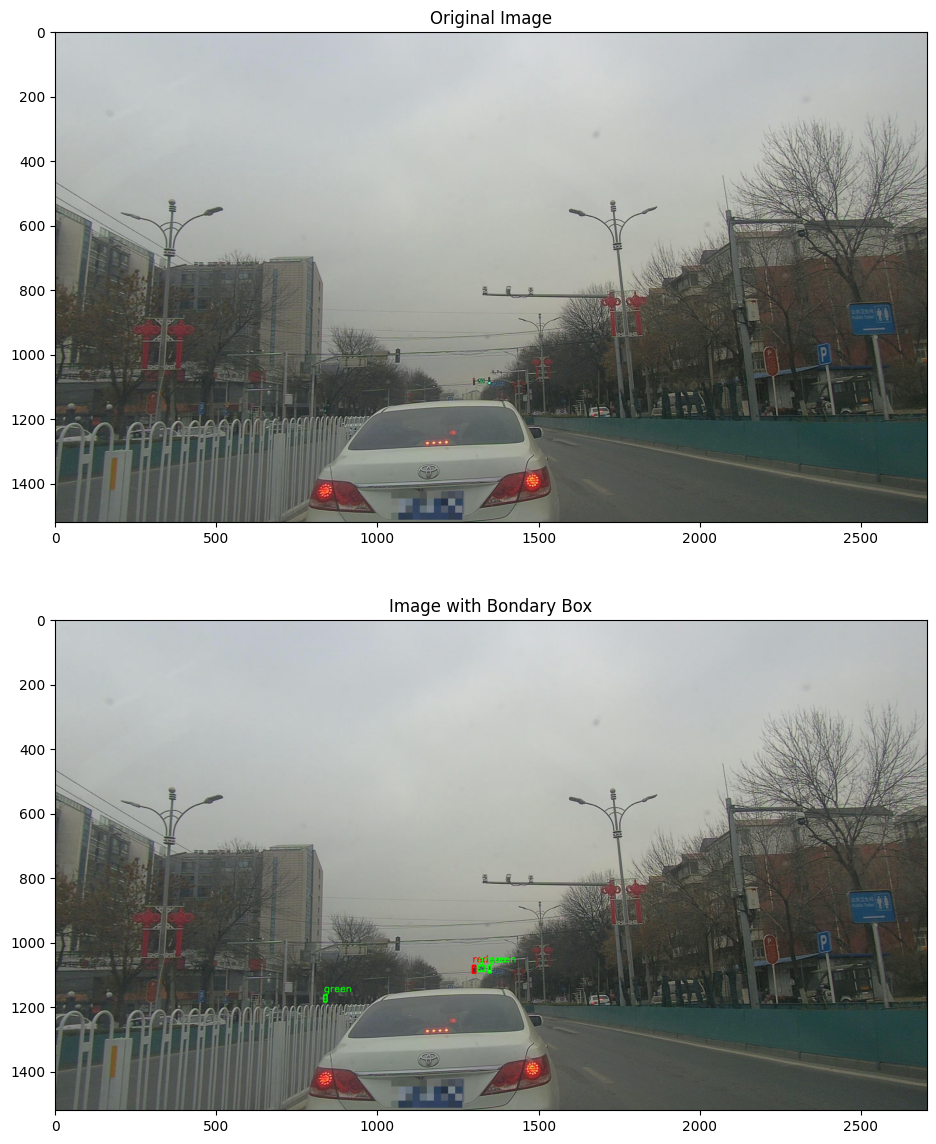

In [19]:
plot_img("00004.jpg")

## Preparing Dataset for Training

In [20]:
_classes = np.insert(classes, 0, "background", axis=0)
class_to_int = {_classes[i] : i for i in range(len(_classes))}
int_to_class = {i : _classes[i] for i in range(len(_classes))}
print("class_to_int : \n",class_to_int)
print("\nint_to_class : \n",int_to_class)

class_to_int : 
 {'background': 0, 'red': 1, 'green': 2, 'yellow': 3}

int_to_class : 
 {0: 'background', 1: 'red', 2: 'green', 3: 'yellow'}


In [21]:
class TrafficLightDetectionDataset(Dataset):

    def __init__(self, dataframe, image_dir, mode='train', transforms=None, resize_factor=0.25):

        super().__init__()

        self.image_names = dataframe['filename'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.mode = mode
        self.resize_factor = resize_factor

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index: int):

        #Retrive Image name and its records (x1, y1, x2, y2, classname) from df
        image_name = self.image_names[index]
        records = self.df[self.df['filename'] == image_name]

        #Loading Image
        image = cv2.imread(self.image_dir + image_name, cv2.IMREAD_COLOR)
        if image is None:
                print("Missing image :", self.image_dir + image_name, cv2.IMREAD_COLOR)
                raise ValueError(f"Failed to load image at index {index}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.mode == 'train':

            #Get bounding box co-ordinates for each box
            boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values

            #Getting labels for each box
            temp_labels = records[['color']].values
            labels = []
            for label in temp_labels:
                label = class_to_int[label[0]]
                labels.append(label)

            #Converting boxes & labels into torch tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

            # Resize the image and the bounding boxes
            height, width, _ = image.shape
            new_height, new_width = int(height * self.resize_factor), int(width * self.resize_factor)
            image = cv2.resize(image, (new_width, new_height))
            boxes = boxes * self.resize_factor
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

            #Creating target
            target = {}
            target['boxes'] = boxes
            target['labels'] = labels
            target['area'] = torch.as_tensor(area, dtype=torch.float32)

            #Transforms
            if self.transforms:
                image = self.transforms(image)


            return image, target, image_name

        elif self.mode == 'test':
            # Resize the image
            height, width, _ = image.shape
            new_height, new_width = int(height * self.resize_factor), int(width * self.resize_factor)
            image = cv2.resize(image, (new_width, new_height))

            if self.transforms:
                image = self.transforms(image)

            return image, image_name


In [22]:
df

filename    xmin    ymin    xmax    ymax  color
0     00001.jpg  1026.5   741.8  1077.5   910.9    red
1     00002.jpg  1418.7  1136.8  1428.3  1149.4    red
2     00003.jpg  2574.3   868.7  2632.3   887.1    red
3     00003.jpg  2252.1   899.6  2300.8   918.7  green
4     00004.jpg   833.3  1163.2   843.6  1184.8  green
...         ...     ...     ...     ...     ...    ...
9417  03000.jpg    78.8  1001.7   107.7  1033.1    red
9418  03000.jpg  1234.8  1058.4  1251.0  1096.4  green
9419  03000.jpg  1264.9  1068.1  1287.6  1086.1  green
9420  03000.jpg  1296.0  1056.6  1311.7  1096.2  green
9421  03000.jpg  1346.5  1057.5  1360.8  1096.6  green

[9422 rows x 6 columns]

# Custom train test and valid

In [23]:
from sklearn.model_selection import train_test_split

def custom_transform(image: np.ndarray):
    # transformed_image = ColorModelFactory.to_color_space(ColorSpace.YUV, image)
    transformed_image = ColorModelFactory.to_color_space(ColorSpace.YCBCr, image)
    # transformed_image = ColorModelFactory.to_color_space(ColorSpace.HSV, image)

    tensor_image = T.ToTensor()(transformed_image)
    return  tensor_image / 255.0

# Example of how to use the transformation
transform = T.Compose([
    T.Lambda(custom_transform),
    # Add other transformations as needed
])

def get_transform():
    return T.Compose([T.ToTensor()])

def collate_fn(batch):
    return tuple(zip(*batch))

# Get unique image names
image_names = df['filename'].unique()

# Split the image names into train, test, and validation sets
train_names, test_valid_names = train_test_split(image_names, test_size=0.3, random_state=42)
test_names, valid_names = train_test_split(test_valid_names, test_size=0.5, random_state=42)

# Create subsets of the DataFrame for train, test, and validation
train_df = df[df['filename'].isin(train_names)]
test_df = df[df['filename'].isin(test_names)]
valid_df = df[df['filename'].isin(valid_names)]

# Dataset object for each subset
train_dataset = TrafficLightDetectionDataset(train_df, DIR_IMAGES, mode='train', transforms=transform)
test_dataset = TrafficLightDetectionDataset(test_df, DIR_IMAGES, mode='train', transforms=transform)
valid_dataset = TrafficLightDetectionDataset(valid_df, DIR_IMAGES, mode='train', transforms=transform)

# DataLoaders for each subset
train_data_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)
test_data_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn)
valid_data_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [24]:
# Utilize GPU if available

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

In [25]:
print(device)

cuda


## Create model

In [26]:
# Create / load model

# Faster - RCNN Model - pretrained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
num_classes = len(class_to_int)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 115MB/s]


In [27]:
# Preparing model for training

# Retriving all trainable parameters from model (for optimizer)
params = [p for p in model.parameters() if p.requires_grad]
# Defininig Optimizer
optimizer = torch.optim.Adam(params, lr = 0.0001)
# LR
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
model.to(device)
# No of epochs
epochs = 7

## Training model

In [28]:
# Training model

itr = 1
total_train_loss = []
for epoch in range(epochs):
    start_time = time.time()
    train_loss = []
    for images, targets, image_names in tqdm(train_data_loader):
        # tqdm

        # Loading images & targets on device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward propagation
        out = model(images, targets)
        losses = sum(loss for loss in out.values())

        # Reseting Gradients
        optimizer.zero_grad()

        # Back propagation
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        # Average loss
        loss_value = losses.item()
        train_loss.append(loss_value)

        if itr % 300 == 0:
            print(f"\n Iteration #{itr} loss: {loss_value:.4f} \n") ## {out}
        itr += 1
    lr_scheduler.step()

    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)
    print(f'Epoch: {epoch+1}')
    print(f'Epoch train loss is {epoch_train_loss:.4f}')


    time_elapsed = time.time() - start_time
    print("Time elapsed: ",time_elapsed)

    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_train_loss
            }, "checkpoint.pth")

 69%|██████▉   | 300/433 [05:58<02:45,  1.24s/it]


 Iteration #300 loss: 0.3370 



100%|██████████| 433/433 [08:30<00:00,  1.18s/it]


Epoch: 1
Epoch train loss is 0.5429
Time elapsed:  510.98042249679565


 39%|███▊      | 167/433 [03:13<05:03,  1.14s/it]


 Iteration #600 loss: 0.4319 



100%|██████████| 433/433 [08:18<00:00,  1.15s/it]


Epoch: 2
Epoch train loss is 0.4042
Time elapsed:  498.73503947257996


  8%|▊         | 34/433 [00:40<07:34,  1.14s/it]


 Iteration #900 loss: 0.2981 



 77%|███████▋  | 334/433 [06:25<01:53,  1.15s/it]


 Iteration #1200 loss: 0.3907 



100%|██████████| 433/433 [08:18<00:00,  1.15s/it]


Epoch: 3
Epoch train loss is 0.3387
Time elapsed:  498.8099193572998


 46%|████▋     | 201/433 [03:53<04:34,  1.18s/it]


 Iteration #1500 loss: 0.4164 



100%|██████████| 433/433 [08:19<00:00,  1.15s/it]


Epoch: 4
Epoch train loss is 0.3140
Time elapsed:  499.5859217643738


 16%|█▌        | 68/433 [01:21<06:59,  1.15s/it]


 Iteration #1800 loss: 0.4285 



 85%|████████▍ | 368/433 [07:07<01:15,  1.17s/it]


 Iteration #2100 loss: 0.2266 



100%|██████████| 433/433 [08:21<00:00,  1.16s/it]


Epoch: 5
Epoch train loss is 0.2952
Time elapsed:  501.56679606437683


 54%|█████▍    | 235/433 [04:33<03:46,  1.14s/it]


 Iteration #2400 loss: 0.1995 



100%|██████████| 433/433 [08:20<00:00,  1.16s/it]


Epoch: 6
Epoch train loss is 0.2911
Time elapsed:  500.7477958202362


 24%|██▎       | 102/433 [02:00<06:28,  1.17s/it]


 Iteration #2700 loss: 0.2837 



 93%|█████████▎| 402/433 [07:46<00:35,  1.14s/it]


 Iteration #3000 loss: 0.2705 



100%|██████████| 433/433 [08:21<00:00,  1.16s/it]


Epoch: 7
Epoch train loss is 0.2908
Time elapsed:  501.41846680641174


In [29]:
df[482:483]

filename    xmin    ymin    xmax    ymax color
482  00190.jpg  1476.6  1121.2  1483.3  1134.1   red

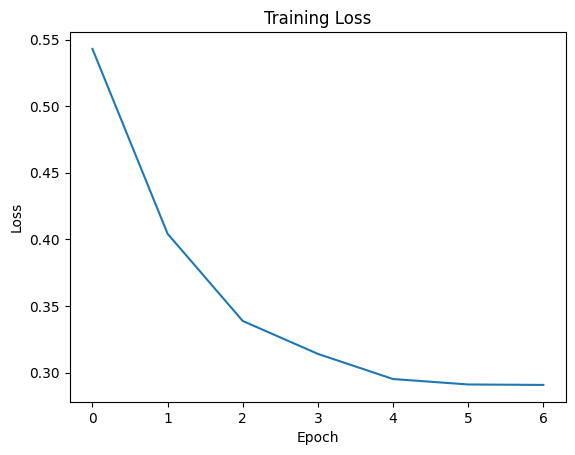

In [30]:
plt.plot(total_train_loss)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [32]:
checkpoint_path = '/content/drive/MyDrive/UNT/CSCE 5222/traffic_light_dataset/model/ycbcr..path'

torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': epoch_train_loss,
}, checkpoint_path)

print(f"Checkpoint saved at: {checkpoint_path}")

Checkpoint saved at: /content/drive/MyDrive/UNT/CSCE 5222/traffic_light_dataset/model/ycbcr..path


# Loading a saved model

In [33]:
# Create / load model

class_to_int = {'background': 0, 'red': 1, 'green': 2, 'yellow': 3}

int_to_class = {0: 'background', 1: 'red', 2: 'green', 3: 'yellow'}

# Faster - RCNN Model - pretrained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
num_classes = len(class_to_int)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Retriving all trainable parameters from model (for optimizer)
params = [p for p in model.parameters() if p.requires_grad]
# Defininig Optimizer
optimizer = torch.optim.Adam(params, lr = 0.0001)
# LR
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In [34]:
# Initialize the model and optimizer
# model = model  # Initialize your model class
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr = 0.0001)  # Initialize your optimizer


# Load the checkpoint
checkpoint = torch.load(checkpoint_path)

# Load the model and optimizer states
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [35]:
# Utilize GPU if available

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

In [36]:
itr = 1
v_loss = []

model.to(device)

start_time = time.time()

for images, targets, image_names in tqdm(test_data_loader):

    #Loading images & targets on device
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    #Forward propagation
    with torch.no_grad():
      out = model(images, targets)
      concatenated_boxes = torch.cat([o['boxes'] for o in out], dim=0)
      # losses = sum(concatenated_boxes.view(-1))
      # losses = sum(o["boxes"].view(-1) for o in out)
      # losses = sum(loss for loss in out.values())
      # losses = sum(out)

    #Average loss
    # loss_value = losses.item()
    # v_loss.append(loss_value)

# val_loss = np.mean(v_loss)
# print(f'Val loss is {val_loss:.4f}')

# time_elapsed = time.time() - start_time
# print("Time elapsed: ",time_elapsed)

  0%|          | 0/93 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 93/93 [01:47<00:00,  1.15s/it]


In [37]:
pred_results = pd.DataFrame(columns = ["filename", "xmin", "ymin",
                                     "xmax", "ymax", "color"])
pred_results.head()

Empty DataFrame
Columns: [filename, xmin, ymin, xmax, ymax, color]
Index: []

In [38]:
# Results - may take few mins, please wait!
threshold = 0 #0.7
model.eval()

for images,_ , image_names in test_data_loader:


    # Forward ->
    images = list(image.to(device) for image in images)
    output = model(images)


    # Converting tensors to array
    boxes = output[0]['boxes'].data.cpu().numpy()
    scores = output[0]['scores'].data.cpu().numpy()
    labels = output[0]['labels'].data.cpu().numpy()

    # Thresholding
    boxes_th = boxes[scores >= threshold].astype(np.int32)
    scores_th = scores[scores >= threshold]
    # print(len(boxes_th))

    # int_to_class - labels
    labels_th = []

    for x in range(len(labels)):
        if scores[x] > threshold:
            labels_th.append(int_to_class[labels[x]])
    #Appending results to csv
    for y in range(len(boxes_th)):

        #Bboxes, classname & image name
        x1 = boxes_th[y][0] * 4
        y1 = boxes_th[y][1] * 4
        x2 = boxes_th[y][2] * 4
        y2 = boxes_th[y][3] * 4
        class_name = labels_th[y]


        # Creating row for df
        row = {"filename" : image_names[0],
               "xmin" : x1, "xmax" : x2,
               "ymin" : y1, "ymax" : y2,
               "color" : class_name}
        print(image_names[0])

        # Appending to df
        pred_results = pred_results.append(row, ignore_index = True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


00030.jpg
00030.jpg
00030.jpg
00030.jpg
00030.jpg
00030.jpg
00030.jpg
00030.jpg
00030.jpg
00030.jpg
00030.jpg
00030.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

00093.jpg
00093.jpg
00093.jpg
00093.jpg
00093.jpg
00093.jpg
00093.jpg
00093.jpg
00093.jpg
00093.jpg
00093.jpg
00093.jpg
00093.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

00147.jpg
00147.jpg
00147.jpg
00147.jpg
00147.jpg
00147.jpg
00147.jpg
00147.jpg
00147.jpg
00147.jpg
00147.jpg
00147.jpg
00147.jpg
00147.jpg
00147.jpg
00147.jpg
00147.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

00169.jpg
00169.jpg
00169.jpg
00169.jpg
00169.jpg
00169.jpg
00169.jpg
00169.jpg
00169.jpg
00169.jpg
00169.jpg
00169.jpg
00169.jpg
00169.jpg
00169.jpg
00169.jpg
00169.jpg
00169.jpg
00169.jpg
00169.jpg
00169.jpg
00169.jpg
00169.jpg
00169.jpg
00169.jpg
00169.jpg
00169.jpg
00169.jpg
00169.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

00169.jpg
00169.jpg
00169.jpg
00169.jpg
00169.jpg
00169.jpg
00169.jpg
00169.jpg
00169.jpg
00212.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)


00244.jpg
00244.jpg
00244.jpg
00244.jpg
00244.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

00288.jpg
00288.jpg
00288.jpg
00288.jpg
00288.jpg
00288.jpg
00288.jpg
00288.jpg
00288.jpg
00288.jpg
00288.jpg
00288.jpg
00288.jpg
00288.jpg
00288.jpg
00288.jpg
00288.jpg
00288.jpg
00288.jpg
00288.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

00364.jpg
00364.jpg
00364.jpg
00364.jpg
00364.jpg
00364.jpg
00364.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg
00384.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

00399.jpg
00399.jpg
00399.jpg
00399.jpg
00399.jpg
00399.jpg
00399.jpg
00399.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

00418.jpg
00418.jpg
00418.jpg
00418.jpg
00418.jpg
00418.jpg
00418.jpg
00418.jpg
00418.jpg
00418.jpg
00418.jpg
00418.jpg
00418.jpg
00418.jpg
00418.jpg
00418.jpg
00418.jpg
00418.jpg
00418.jpg
00418.jpg
00418.jpg
00418.jpg
00418.jpg
00418.jpg
00418.jpg
00418.jpg
00418.jpg
00418.jpg
00418.jpg
00418.jpg
00418.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

00455.jpg
00455.jpg
00455.jpg
00455.jpg
00455.jpg
00455.jpg
00455.jpg
00455.jpg
00455.jpg
00455.jpg
00455.jpg
00455.jpg
00455.jpg
00455.jpg
00455.jpg
00455.jpg
00455.jpg
00455.jpg
00455.jpg
00455.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

00466.jpg
00466.jpg
00466.jpg
00466.jpg
00466.jpg
00466.jpg
00466.jpg
00466.jpg
00466.jpg
00466.jpg
00466.jpg
00466.jpg
00466.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg
00521.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg
00537.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

00561.jpg
00561.jpg
00561.jpg
00561.jpg
00561.jpg
00561.jpg
00561.jpg
00561.jpg
00561.jpg
00561.jpg
00561.jpg
00561.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

00584.jpg
00584.jpg
00584.jpg
00584.jpg
00584.jpg
00584.jpg
00584.jpg
00584.jpg
00584.jpg
00584.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

00603.jpg
00603.jpg
00603.jpg
00603.jpg
00603.jpg
00603.jpg
00603.jpg
00603.jpg
00603.jpg
00603.jpg
00603.jpg
00603.jpg
00603.jpg
00603.jpg
00603.jpg
00603.jpg
00603.jpg
00603.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

00603.jpg
00603.jpg
00603.jpg
00603.jpg
00603.jpg
00603.jpg
00603.jpg
00603.jpg
00603.jpg
00603.jpg
00603.jpg
00603.jpg
00603.jpg
00603.jpg
00603.jpg
00603.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

00635.jpg
00635.jpg
00635.jpg
00635.jpg
00635.jpg
00635.jpg
00635.jpg
00635.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

00663.jpg
00663.jpg
00663.jpg
00663.jpg
00663.jpg
00663.jpg
00663.jpg
00663.jpg
00663.jpg
00663.jpg
00663.jpg
00663.jpg
00663.jpg
00663.jpg
00663.jpg
00663.jpg
00663.jpg
00663.jpg
00663.jpg
00663.jpg
00663.jpg
00663.jpg
00663.jpg
00663.jpg
00663.jpg
00663.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

00663.jpg
00663.jpg
00663.jpg
00663.jpg
00663.jpg
00663.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

00693.jpg
00693.jpg
00693.jpg
00693.jpg
00693.jpg
00693.jpg
00693.jpg
00693.jpg
00693.jpg
00693.jpg
00693.jpg
00693.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

00730.jpg
00730.jpg
00730.jpg
00730.jpg
00730.jpg
00730.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

00760.jpg
00760.jpg
00760.jpg
00760.jpg
00760.jpg
00760.jpg
00760.jpg
00760.jpg
00760.jpg
00760.jpg
00760.jpg
00760.jpg
00760.jpg
00760.jpg
00760.jpg
00760.jpg
00760.jpg
00760.jpg
00760.jpg
00760.jpg
00760.jpg
00760.jpg
00760.jpg
00760.jpg
00760.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

00777.jpg
00777.jpg
00777.jpg
00777.jpg
00777.jpg
00777.jpg
00777.jpg
00777.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

00852.jpg
00852.jpg
00852.jpg
00852.jpg
00852.jpg
00852.jpg
00852.jpg
00852.jpg
00852.jpg
00852.jpg
00852.jpg
00852.jpg
00852.jpg
00852.jpg
00852.jpg
00852.jpg
00852.jpg
00852.jpg
00852.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

00901.jpg
00901.jpg
00901.jpg
00901.jpg
00901.jpg
00901.jpg
00901.jpg
00901.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

00965.jpg
00965.jpg
00965.jpg
00965.jpg
00965.jpg
00965.jpg
00965.jpg
00965.jpg
00965.jpg
00965.jpg
00965.jpg
00965.jpg
00965.jpg
00965.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

00994.jpg
00994.jpg
00994.jpg
00994.jpg
00994.jpg
00994.jpg
00994.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

01044.jpg
01044.jpg
01044.jpg
01044.jpg
01044.jpg
01044.jpg
01044.jpg
01044.jpg
01044.jpg
01044.jpg
01044.jpg
01044.jpg
01044.jpg
01044.jpg
01044.jpg
01044.jpg
01044.jpg
01044.jpg
01044.jpg
01044.jpg
01044.jpg
01044.jpg
01044.jpg
01044.jpg
01044.jpg
01044.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

01063.jpg
01063.jpg
01063.jpg
01063.jpg
01063.jpg
01063.jpg
01063.jpg
01063.jpg
01063.jpg
01063.jpg
01063.jpg
01063.jpg
01063.jpg
01063.jpg
01063.jpg
01063.jpg
01063.jpg
01063.jpg
01063.jpg
01063.jpg
01063.jpg
01063.jpg
01063.jpg
01063.jpg
01063.jpg
01063.jpg
01063.jpg
01063.jpg
01063.jpg
01063.jpg
01063.jpg
01063.jpg
01063.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

01080.jpg
01080.jpg
01080.jpg
01080.jpg
01080.jpg
01080.jpg
01080.jpg
01080.jpg
01080.jpg
01080.jpg
01080.jpg
01080.jpg
01080.jpg
01080.jpg
01080.jpg
01080.jpg
01080.jpg
01080.jpg
01080.jpg
01080.jpg
01080.jpg
01080.jpg
01080.jpg
01080.jpg
01080.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

01107.jpg
01107.jpg
01107.jpg
01107.jpg
01107.jpg
01107.jpg
01107.jpg
01107.jpg
01107.jpg
01107.jpg
01107.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

01129.jpg
01129.jpg
01129.jpg
01129.jpg
01129.jpg
01129.jpg
01129.jpg
01129.jpg
01129.jpg
01129.jpg
01129.jpg
01129.jpg
01129.jpg
01129.jpg
01129.jpg
01129.jpg
01129.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

01172.jpg
01172.jpg
01172.jpg
01172.jpg
01172.jpg
01172.jpg
01172.jpg
01172.jpg
01172.jpg
01172.jpg
01172.jpg
01172.jpg
01172.jpg
01172.jpg
01172.jpg
01172.jpg
01172.jpg
01172.jpg
01172.jpg
01172.jpg
01172.jpg
01172.jpg
01172.jpg
01172.jpg
01172.jpg
01172.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

01203.jpg
01203.jpg
01203.jpg
01203.jpg
01203.jpg
01203.jpg
01203.jpg
01203.jpg
01203.jpg
01203.jpg
01203.jpg
01203.jpg
01203.jpg
01203.jpg
01203.jpg
01203.jpg
01203.jpg
01203.jpg
01203.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

01256.jpg
01256.jpg
01256.jpg
01256.jpg
01256.jpg
01256.jpg
01256.jpg
01256.jpg
01256.jpg
01256.jpg
01256.jpg
01256.jpg
01256.jpg
01256.jpg
01256.jpg
01256.jpg
01256.jpg
01256.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

01288.jpg
01288.jpg
01288.jpg
01288.jpg
01288.jpg
01288.jpg
01288.jpg
01288.jpg
01288.jpg
01288.jpg
01288.jpg
01288.jpg
01288.jpg
01288.jpg
01288.jpg
01288.jpg
01288.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

01303.jpg
01303.jpg
01303.jpg
01303.jpg
01303.jpg
01303.jpg
01303.jpg
01303.jpg
01303.jpg
01303.jpg
01303.jpg
01303.jpg
01303.jpg
01303.jpg
01303.jpg
01303.jpg
01303.jpg
01303.jpg
01303.jpg
01303.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

01334.jpg
01334.jpg
01334.jpg
01334.jpg
01334.jpg
01334.jpg
01334.jpg
01334.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

01366.jpg
01366.jpg
01366.jpg
01366.jpg
01366.jpg
01366.jpg
01366.jpg
01366.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

01379.jpg
01379.jpg
01379.jpg
01379.jpg
01379.jpg
01379.jpg
01379.jpg
01379.jpg
01379.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

01451.jpg
01451.jpg
01451.jpg
01451.jpg
01451.jpg
01451.jpg
01451.jpg
01451.jpg
01451.jpg
01451.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

01476.jpg
01476.jpg
01476.jpg
01476.jpg
01476.jpg
01476.jpg
01476.jpg
01476.jpg
01476.jpg
01476.jpg
01476.jpg
01476.jpg
01476.jpg
01476.jpg
01476.jpg
01476.jpg
01476.jpg
01476.jpg
01476.jpg
01476.jpg
01476.jpg
01476.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

01509.jpg
01509.jpg
01509.jpg
01509.jpg
01509.jpg
01509.jpg
01509.jpg
01509.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

01530.jpg
01530.jpg
01530.jpg
01530.jpg
01530.jpg
01530.jpg
01530.jpg
01530.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

01552.jpg
01552.jpg
01552.jpg
01552.jpg
01552.jpg
01552.jpg
01552.jpg
01552.jpg
01552.jpg
01552.jpg
01552.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

01589.jpg
01589.jpg
01589.jpg
01589.jpg
01589.jpg
01589.jpg
01589.jpg
01589.jpg
01589.jpg
01589.jpg
01589.jpg
01589.jpg
01589.jpg
01589.jpg
01589.jpg
01589.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

01614.jpg
01614.jpg
01614.jpg
01614.jpg
01614.jpg
01614.jpg
01614.jpg
01614.jpg
01614.jpg
01614.jpg
01614.jpg
01614.jpg
01614.jpg
01614.jpg
01614.jpg
01614.jpg
01614.jpg
01614.jpg
01614.jpg
01614.jpg

<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth


01614.jpg
01614.jpg
01614.jpg
01614.jpg
01614.jpg
01614.jpg
01614.jpg
01614.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

01643.jpg
01643.jpg
01643.jpg
01643.jpg
01643.jpg
01643.jpg
01643.jpg
01643.jpg
01643.jpg
01643.jpg
01643.jpg
01643.jpg
01643.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

01690.jpg
01690.jpg
01690.jpg
01690.jpg
01690.jpg
01690.jpg
01690.jpg
01690.jpg
01690.jpg
01690.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

01711.jpg
01711.jpg
01711.jpg
01711.jpg
01711.jpg
01711.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg
01740.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

01776.jpg
01776.jpg
01776.jpg
01776.jpg
01776.jpg
01776.jpg
01776.jpg
01776.jpg
01776.jpg
01776.jpg
01776.jpg
01776.jpg
01776.jpg
01776.jpg
01776.jpg
01776.jpg
01776.jpg
01776.jpg
01776.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

01803.jpg
01803.jpg
01803.jpg
01803.jpg
01803.jpg
01803.jpg
01803.jpg
01803.jpg
01803.jpg
01803.jpg
01803.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

01852.jpg
01852.jpg
01852.jpg
01852.jpg
01852.jpg
01852.jpg
01852.jpg
01852.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

01871.jpg
01871.jpg
01871.jpg
01871.jpg
01871.jpg
01871.jpg
01871.jpg
01871.jpg
01871.jpg
01871.jpg
01871.jpg
01871.jpg
01871.jpg
01871.jpg
01871.jpg
01871.jpg
01871.jpg
01871.jpg
01871.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

01897.jpg
01897.jpg
01897.jpg
01897.jpg
01897.jpg
01897.jpg
01897.jpg
01897.jpg
01897.jpg
01897.jpg
01897.jpg
01897.jpg
01897.jpg
01897.jpg
01897.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

01905.jpg
01905.jpg
01905.jpg
01905.jpg
01905.jpg
01905.jpg
01905.jpg
01905.jpg
01905.jpg
01905.jpg
01905.jpg
01905.jpg
01905.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

01931.jpg
01931.jpg
01931.jpg
01931.jpg
01931.jpg
01931.jpg
01931.jpg
01931.jpg
01931.jpg
01931.jpg
01931.jpg
01931.jpg
01931.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

01997.jpg
01997.jpg
01997.jpg
01997.jpg
01997.jpg
01997.jpg
01997.jpg
01997.jpg
01997.jpg
01997.jpg
01997.jpg
01997.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

02029.jpg
02029.jpg
02029.jpg
02029.jpg
02029.jpg
02029.jpg
02029.jpg
02029.jpg
02029.jpg
02029.jpg
02029.jpg
02029.jpg
02029.jpg
02029.jpg
02029.jpg
02029.jpg
02029.jpg
02029.jpg
02029.jpg
02029.jpg
02029.jpg
02029.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

02075.jpg
02075.jpg
02075.jpg
02075.jpg
02075.jpg
02075.jpg
02075.jpg
02075.jpg
02075.jpg
02075.jpg
02075.jpg
02075.jpg
02075.jpg
02075.jpg
02075.jpg
02075.jpg
02075.jpg
02075.jpg
02075.jpg
02075.jpg
02075.jpg
02075.jpg
02075.jpg
02075.jpg
02075.jpg
02075.jpg
02075.jpg
02075.jpg
02075.jpg
02075.jpg
02075.jpg
02075.jpg
02075.jpg
02075.jpg
02075.jpg
02075.jpg
02075.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg
02111.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

02136.jpg
02136.jpg
02136.jpg
02136.jpg
02136.jpg
02136.jpg
02136.jpg
02136.jpg
02136.jpg
02136.jpg
02136.jpg
02136.jpg
02136.jpg
02136.jpg
02136.jpg
02136.jpg
02136.jpg
02136.jpg
02136.jpg
02136.jpg
02136.jpg
02136.jpg
02136.jpg
02136.jpg
02136.jpg
02136.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

02154.jpg
02154.jpg
02154.jpg
02154.jpg
02154.jpg
02154.jpg
02154.jpg
02154.jpg
02154.jpg
02154.jpg
02154.jpg
02154.jpg
02154.jpg
02154.jpg
02154.jpg
02154.jpg
02154.jpg
02154.jpg
02154.jpg
02154.jpg
02154.jpg
02154.jpg
02154.jpg
02154.jpg
02154.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

02172.jpg
02172.jpg
02172.jpg
02172.jpg
02172.jpg
02172.jpg
02172.jpg
02172.jpg
02172.jpg
02172.jpg
02172.jpg
02172.jpg
02172.jpg
02172.jpg
02172.jpg
02172.jpg
02172.jpg
02172.jpg
02172.jpg
02172.jpg
02172.jpg
02172.jpg
02172.jpg
02172.jpg
02172.jpg
02172.jpg
02172.jpg
02172.jpg
02172.jpg
02172.jpg
02172.jpg
02172.jpg
02172.jpg
02172.jpg
02172.jpg
02172.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

02178.jpg
02178.jpg
02178.jpg
02178.jpg
02178.jpg
02178.jpg
02178.jpg
02178.jpg
02178.jpg
02178.jpg
02178.jpg
02178.jpg
02178.jpg
02178.jpg
02178.jpg
02178.jpg
02178.jpg
02178.jpg
02178.jpg
02178.jpg
02178.jpg
02178.jpg
02178.jpg
02178.jpg
02178.jpg
02178.jpg
02178.jpg
02178.jpg
02178.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

02234.jpg
02234.jpg
02234.jpg
02234.jpg
02234.jpg
02234.jpg
02234.jpg
02234.jpg
02234.jpg
02234.jpg
02234.jpg
02234.jpg
02234.jpg
02234.jpg
02234.jpg
02234.jpg
02234.jpg
02234.jpg
02234.jpg
02234.jpg
02234.jpg
02234.jpg
02234.jpg
02234.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

02267.jpg
02267.jpg
02267.jpg
02267.jpg
02267.jpg
02267.jpg
02267.jpg
02267.jpg
02267.jpg
02267.jpg
02267.jpg
02267.jpg
02267.jpg
02267.jpg
02267.jpg
02267.jpg
02267.jpg
02267.jpg
02267.jpg
02267.jpg
02267.jpg
02267.jpg
02267.jpg
02267.jpg
02267.jpg
02267.jpg
02267.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

02295.jpg
02295.jpg
02295.jpg
02295.jpg
02295.jpg
02295.jpg
02295.jpg
02295.jpg
02295.jpg
02295.jpg
02295.jpg
02295.jpg
02295.jpg
02295.jpg
02295.jpg
02295.jpg
02295.jpg
02295.jpg
02295.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

02340.jpg
02340.jpg
02340.jpg
02340.jpg
02340.jpg
02340.jpg
02340.jpg
02340.jpg
02340.jpg
02340.jpg
02340.jpg
02340.jpg
02340.jpg
02340.jpg
02340.jpg
02340.jpg
02340.jpg
02340.jpg
02340.jpg
02340.jpg
02340.jpg
02340.jpg
02340.jpg
02340.jpg
02340.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

02362.jpg
02362.jpg
02362.jpg
02362.jpg
02362.jpg
02362.jpg
02362.jpg
02362.jpg
02362.jpg
02362.jpg
02362.jpg
02362.jpg
02362.jpg
02362.jpg
02362.jpg
02362.jpg
02362.jpg
02362.jpg
02362.jpg
02362.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

02374.jpg
02374.jpg
02374.jpg
02374.jpg
02374.jpg
02374.jpg
02374.jpg
02374.jpg
02374.jpg
02374.jpg
02374.jpg
02374.jpg
02374.jpg
02374.jpg
02374.jpg
02374.jpg
02374.jpg
02374.jpg
02374.jpg
02374.jpg
02374.jpg
02374.jpg
02374.jpg
02374.jpg
02374.jpg
02374.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

02392.jpg
02392.jpg
02392.jpg
02392.jpg
02392.jpg
02392.jpg
02392.jpg
02392.jpg
02392.jpg
02392.jpg
02392.jpg
02392.jpg
02392.jpg
02392.jpg
02392.jpg
02392.jpg
02392.jpg
02392.jpg
02392.jpg
02392.jpg
02392.jpg
02392.jpg
02392.jpg
02392.jpg
02392.jpg
02392.jpg
02392.jpg
02392.jpg
02392.jpg
02392.jpg
02392.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

02438.jpg
02438.jpg
02438.jpg
02438.jpg
02438.jpg
02438.jpg
02438.jpg
02438.jpg
02438.jpg
02438.jpg
02438.jpg
02438.jpg
02438.jpg
02438.jpg
02438.jpg
02438.jpg
02438.jpg
02438.jpg
02438.jpg
02438.jpg
02438.jpg
02438.jpg
02438.jpg
02438.jpg
02438.jpg
02438.jpg
02438.jpg
02438.jpg
02438.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

02488.jpg
02488.jpg
02488.jpg
02488.jpg
02488.jpg
02488.jpg
02488.jpg
02488.jpg
02488.jpg
02488.jpg
02488.jpg
02488.jpg
02488.jpg
02488.jpg
02488.jpg
02488.jpg
02488.jpg
02488.jpg
02488.jpg
02488.jpg
02488.jpg
02488.jpg
02488.jpg
02488.jpg
02488.jpg
02488.jpg
02488.jpg
02488.jpg
02488.jpg
02488.jpg
02488.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

02488.jpg
02488.jpg
02488.jpg
02488.jpg
02488.jpg
02488.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

02558.jpg
02558.jpg
02558.jpg
02558.jpg
02558.jpg
02558.jpg
02558.jpg
02558.jpg
02558.jpg
02558.jpg
02558.jpg
02558.jpg
02558.jpg
02558.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

02608.jpg
02608.jpg
02608.jpg
02608.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)


02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg
02633.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

02679.jpg
02679.jpg
02679.jpg
02679.jpg
02679.jpg
02679.jpg
02679.jpg
02679.jpg
02679.jpg
02679.jpg
02679.jpg
02679.jpg
02679.jpg
02679.jpg
02679.jpg
02679.jpg
02679.jpg
02679.jpg
02679.jpg
02679.jpg
02679.jpg
02679.jpg
02679.jpg
02679.jpg
02679.jpg
02679.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

02694.jpg
02694.jpg
02694.jpg
02694.jpg
02694.jpg
02694.jpg
02694.jpg
02694.jpg
02694.jpg
02694.jpg
02694.jpg
02694.jpg
02694.jpg
02694.jpg
02694.jpg
02694.jpg
02694.jpg
02694.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

02722.jpg
02722.jpg
02722.jpg
02722.jpg
02722.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

02742.jpg
02742.jpg
02742.jpg
02742.jpg
02742.jpg
02742.jpg
02742.jpg
02742.jpg
02742.jpg
02742.jpg
02742.jpg
02742.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

02776.jpg
02776.jpg
02776.jpg
02776.jpg
02776.jpg
02776.jpg
02776.jpg
02776.jpg
02776.jpg
02776.jpg
02776.jpg
02776.jpg
02776.jpg
02776.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

02869.jpg
02869.jpg
02869.jpg
02869.jpg
02869.jpg
02869.jpg
02869.jpg
02869.jpg
02869.jpg
02869.jpg
02869.jpg
02869.jpg
02869.jpg
02869.jpg
02869.jpg
02869.jpg
02869.jpg
02869.jpg
02869.jpg
02869.jpg
02869.jpg
02869.jpg
02869.jpg
02869.jpg
02869.jpg
02869.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

02906.jpg
02906.jpg
02906.jpg
02906.jpg
02906.jpg
02906.jpg
02906.jpg
02906.jpg
02906.jpg
02906.jpg
02906.jpg
02906.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

02926.jpg
02926.jpg
02926.jpg
02926.jpg
02926.jpg
02926.jpg
02926.jpg
02926.jpg
02926.jpg
02926.jpg
02926.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

02959.jpg
02959.jpg
02959.jpg
02959.jpg
02959.jpg
02959.jpg
02959.jpg
02959.jpg
02959.jpg
02959.jpg
02959.jpg
02959.jpg
02959.jpg
02959.jpg
02959.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

02984.jpg
02984.jpg
02984.jpg
02984.jpg
02984.jpg
02984.jpg
02984.jpg
02984.jpg
02984.jpg
02984.jpg
02984.jpg
02984.jpg
02984.jpg
02984.jpg
02984.jpg
02984.jpg
02984.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

02999.jpg
02999.jpg
02999.jpg
02999.jpg
02999.jpg
02999.jpg
02999.jpg
02999.jpg
02999.jpg
02999.jpg
02999.jpg
02999.jpg
02999.jpg
02999.jpg
02999.jpg
02999.jpg
02999.jpg
02999.jpg
02999.jpg


<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-38-f9364b13e2af>:48: FutureWarning: The frame.append meth

In [39]:
pred_results

filename  xmin  ymin  xmax  ymax  color
0     00030.jpg  1680  1048  1704  1096    red
1     00030.jpg  1568   888  1584   928    red
2     00030.jpg  1456   888  1472   928    red
3     00030.jpg  1500   900  1552   928    red
4     00030.jpg  1452   888  1480   920    red
...         ...   ...   ...   ...   ...    ...
1864  02999.jpg  1192  1024  1292  1072  green
1865  02999.jpg  1868  1180  1880  1208  green
1866  02999.jpg   100  1176   120  1208  green
1867  02999.jpg  1872  1200  1884  1216  green
1868  02999.jpg  1252  1024  1272  1072    red

[1869 rows x 6 columns]

In [40]:
test_df

filename    xmin    ymin    xmax    ymax  color
83    00030.jpg  1688.4  1049.9  1702.9  1098.8    red
84    00030.jpg  1568.3   891.1  1584.5   937.7    red
85    00030.jpg  1502.1   905.2  1534.9   929.2    red
86    00030.jpg  1456.4   889.9  1472.3   936.7    red
98    00036.jpg  1115.6  1115.1  1133.0  1135.9    red
...         ...     ...     ...     ...     ...    ...
9417  03000.jpg    78.8  1001.7   107.7  1033.1    red
9418  03000.jpg  1234.8  1058.4  1251.0  1096.4  green
9419  03000.jpg  1264.9  1068.1  1287.6  1086.1  green
9420  03000.jpg  1296.0  1056.6  1311.7  1096.2  green
9421  03000.jpg  1346.5  1057.5  1360.8  1096.6  green

[1454 rows x 6 columns]

In [41]:
basePath = '/content/drive/MyDrive/UNT/CSCE 5222/traffic_light_dataset/model'
pred_results.to_csv(basePath+'pred_results_ycbcr.csv', index = False)

In [43]:
pred_df = pd.read_csv(basePath+'pred_results_ycbcr.csv')
pred_df

filename  xmin  ymin  xmax  ymax  color
0     00030.jpg  1680  1048  1704  1096    red
1     00030.jpg  1568   888  1584   928    red
2     00030.jpg  1456   888  1472   928    red
3     00030.jpg  1500   900  1552   928    red
4     00030.jpg  1452   888  1480   920    red
...         ...   ...   ...   ...   ...    ...
1864  02999.jpg  1192  1024  1292  1072  green
1865  02999.jpg  1868  1180  1880  1208  green
1866  02999.jpg   100  1176   120  1208  green
1867  02999.jpg  1872  1200  1884  1216  green
1868  02999.jpg  1252  1024  1272  1072    red

[1869 rows x 6 columns]

In [55]:
DIR_INPUT = '/content/drive/MyDrive/UNT/CSCE 5222/traffic_light_dataset/kaggle_dataset/'

DIR_IMAGES = DIR_INPUT + "train_dataset/train_images/"
DIR_IMAGES_TEST = DIR_INPUT + "test_dataset/test_images/"

def plot_img_test(image_name):

    # fig, ax = plt.subplots(1, 1, figsize = (14, 14))
    # ax = ax.flatten()

    bbox = pred_df[pred_df['filename'] == image_name]
    img_path = os.path.join(DIR_IMAGES_TEST, image_name)
    if os.path.exists(img_path) == False:
      img_path = os.path.join(DIR_IMAGES, image_name)
    # else:
    #   img_path = os.path.join(DIR_IMAGES, image_name)

    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image2 = image

    # ax[0].set_title('Original Image')
    # ax[0].imshow(image)

    for idx, row in bbox.iterrows():
        x1 = row['xmin']
        y1 = row['ymin']
        x2 = row['xmax']
        y2 = row['ymax']
        label = row['color']
        if label == 'red':
            color_brg = (255,0,0)
        elif label == 'green':
            color_brg = (0,255,0)
        elif label == 'yellow':
            color_brg = (0,255,255)

        cv2.rectangle(image2, (int(x1),int(y1)), (int(x2),int(y2)), color_brg, 3)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image2, label, (int(x1),int(y1-10)), font, 1, color_brg, 2)

    plt.figure(figsize=(10,10))
    plt.title('Image with Bondary Box')
    plt.imshow(image2)

    plt.show()

#YCBCr Predictions

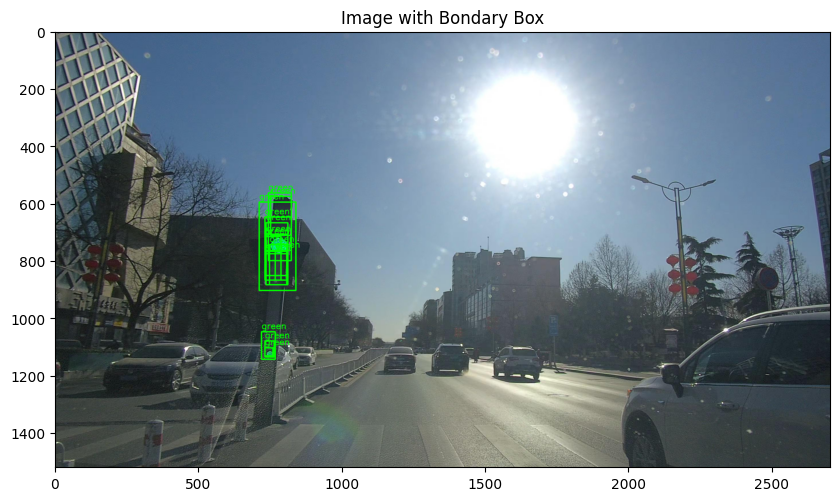

In [56]:
plot_img_test('00093.jpg')

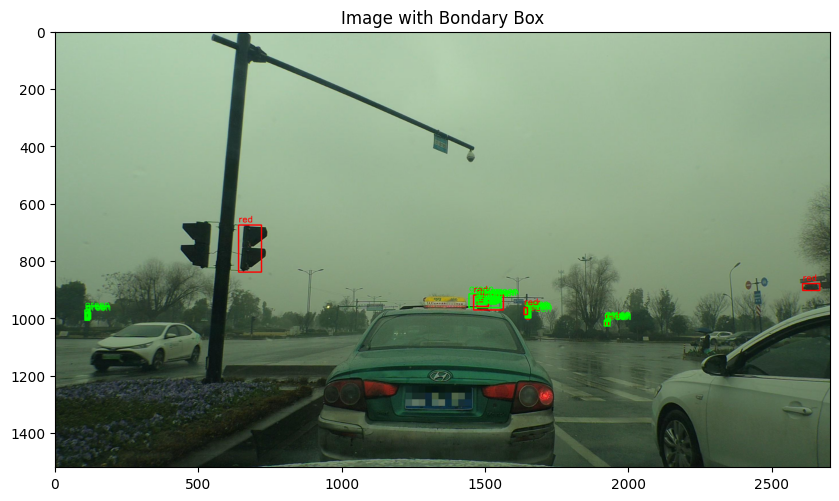

In [59]:
plot_img_test('02577.jpg')

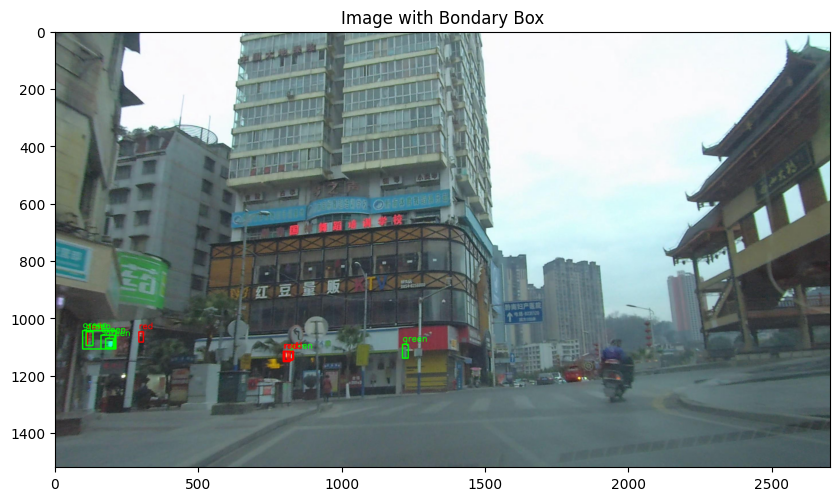

In [60]:
plot_img_test('01552.jpg')

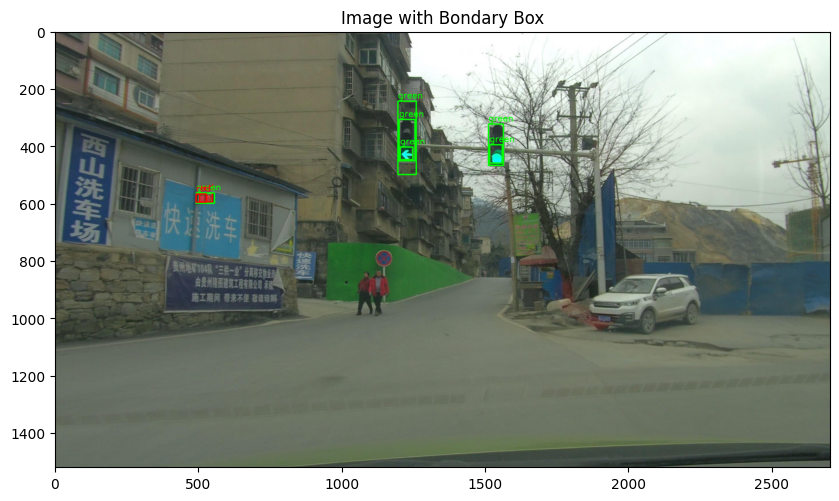

In [61]:
plot_img_test('01530.jpg')

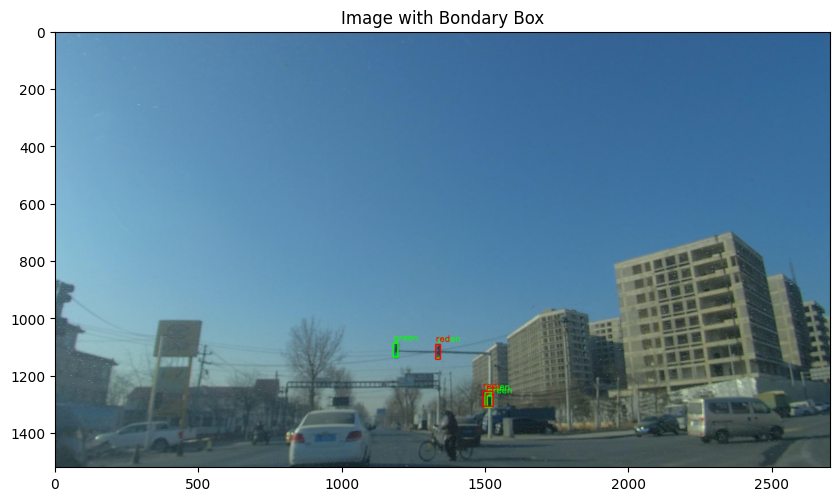

In [62]:
plot_img_test('00994.jpg')

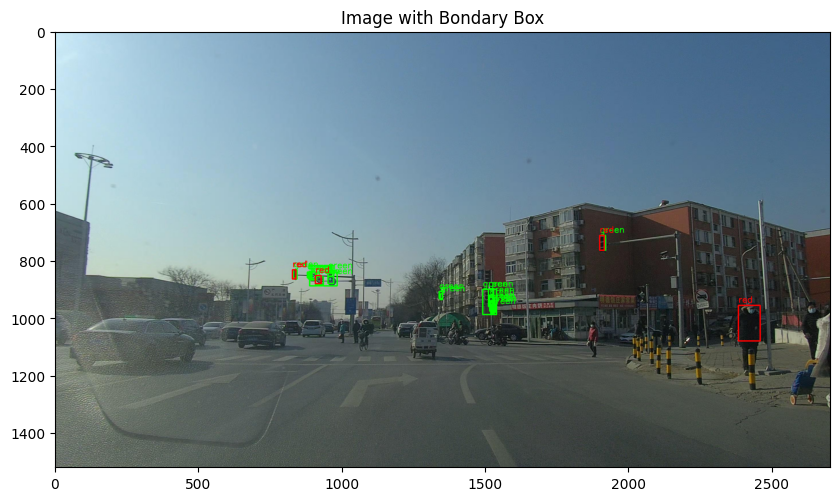

In [63]:
plot_img_test('00760.jpg')

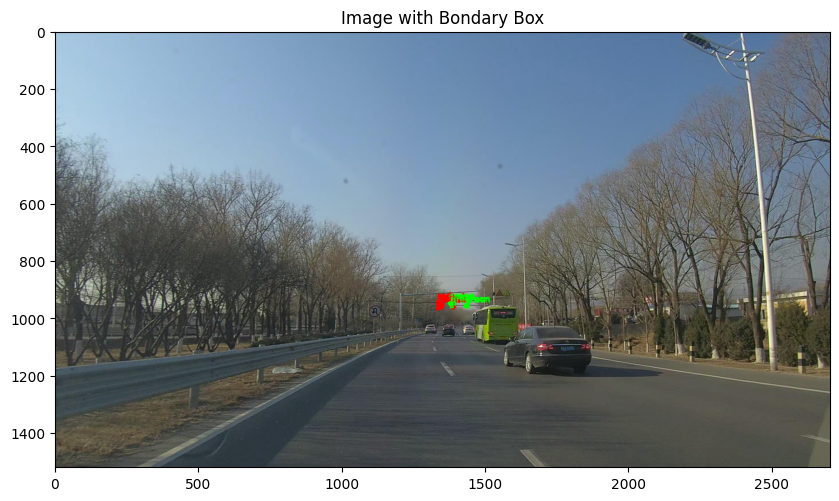

In [64]:
plot_img_test('00169.jpg')

# Evaluation

In [65]:
ground_truth = test_df
pred_data = pred_df

In [66]:
def csv_to_dict(df):

    # Format csv data to dictonary
    dict_data = {}
    for idx, row in df.iterrows():
        filename = row['filename']
        bbox = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]
        label = row['color']

        if filename not in dict_data:
            dict_data[filename] = []

        dict_data[filename].append({'bbox': bbox, 'label': label})
    return dict_data

In [67]:
ground_truth = csv_to_dict(ground_truth)
pred_data = csv_to_dict(pred_data)

In [68]:
from shapely.geometry import box
from shapely.ops import unary_union

def calculate_iou(gt_bbox, pred_bbox):
    # Create shapely objects for ground truth and predicted bounding boxes
    gt_box = box(*gt_bbox)
    pred_box = box(*pred_bbox)

    # Calculate intersection and union
    intersection = gt_box.intersection(pred_box).area
    union = unary_union([gt_box, pred_box]).area

    # Calculate IoU
    iou = intersection / union
    return iou

In [69]:
def evaluate_result(ground_truth, pred):
    iou_threshold = 0.5

    predictions = {}

    # Initializing counters
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    total_instances = 0

    # Evaluating predictions
    for filename, pred in ground_truth.items():
        if filename in ground_truth:
            gt_list = ground_truth[filename]

    #         total_instances += 1
            total_instances += len(gt_list)

            for pred in pred:
                pred_bbox = pred['bbox']

                # Finding the ground truth bounding box with highest IoU
                max_iou = 0
                match_found = False

                for gt in gt_list:
                    gt_bbox = gt['bbox']
                    iou = calculate_iou(gt_bbox, pred_bbox)

                    if iou > max_iou:
                        max_iou = iou

                if max_iou >= iou_threshold:
                    true_positives += 1
                else:
                    false_positives += 1


    false_negatives = total_instances - true_positives

    # Accuracy
    true_negatives = total_instances - (true_positives + false_positives + false_negatives)
    accuracy = (true_positives + true_negatives)/total_instances

    # Calculating precision, recall, and F1 score
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)

    return(accuracy, precision, recall, f1_score)

In [70]:
evaluate_result(ground_truth, pred_data)

(1.0, 1.0, 1.0, 1.0)